In [1]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display
from skimage.morphology import label
from scipy.ndimage import measurements
import itertools

from z3 import *

In [2]:
url='https://www.janestreet.com/puzzles/pent-up-frustration-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([[i,j] for i,j in enumerate(y)])
display(Markdown("### "+y[7]+"\n\n"+str("\n".join(y[10:18]))))

# Built a integer linear programming pentomino solver (in z3) and try to maximise. Works for 6x6 but 7x7 and bigger 
# looks like it takes too long
#
# Papers to look at
# https://www.jstage.jst.go.jp/article/ipsjjip/23/3/23_252/_pdf/-char/ja


### 'Pent-up' Frustration

Place as many distinct pentominoes as you want into an 8-by-8 grid, in such a
way that the placement is “tight” — i.e., no piece(s) can freely slide around
within the grid.
The score for a given placement is the
sum of the square roots of the areas of
the empty regions
in the grid.
What is the largest score you can obtain?
This month, when you send in your entry, please send in your grid. Please use
the
standard
notation
, — i.e. F,
I, L, N, P, T, U, V, W, X, Y, Z — and use “.” to denote empty spaces. (So the
top row in the valid placement example would be “…Z..LL”)

<img src='https://www.janestreet.com/puzzles/20181101_pent-up.png' width =300>

In [3]:


def reset(positions):
    min_x, min_y = min(positions, key=lambda x:x[::-1])
    return tuple(sorted((x-min_x, y-min_y) for x, y in positions))

def variation(positions):
    return list({reset(var) for var in (
        positions,
        [(-y,  x) for x, y in positions], # Anti-clockwise 90
        [(-x, -y) for x, y in positions], # 180
        [( y, -x) for x, y in positions], # Clockwise 90

        [(-x,  y) for x, y in positions], # Mirror vertical
        [(-y, -x) for x, y in positions], # Mirror diagonal
        [( x, -y) for x, y in positions], # Mirror horizontal
    )})

def orientation(x,y,shape,A,B):
    for (alpha,beta) in shape:
        links = []
        for (i,j) in shape:
            if (i,j) !=(alpha,beta):
                if  (x+i-alpha >= 0) & (x+i-alpha <A) & (y+j-beta >=0) &  (y+j-beta <B):
                     links.append((x+i-alpha,y+j-beta))
    
            if len(links) == len(shape)-1:
                yield links
            
def forced(x,y,A,B,n):
    shapes = [
    (((0, 1), (1, 0), (1, 1), (1, 2), (2, 0)), "F"),
    (((0, 0), (0, 1), (0, 2), (0, 3), (0, 4)), "I"),
    (((0, 0), (0, 1), (0, 2), (0, 3), (1, 3)), "L"),
    (((0, 2), (0, 3), (1, 0), (1, 1), (1, 2)), "N"),
    (((0, 0), (0, 1), (0, 2), (1, 0), (1, 1)), "P"),
    (((0, 0), (1, 0), (1, 1), (1, 2), (2, 0)), "T"),
    (((0, 0), (0, 1), (1, 1), (2, 0), (2, 1)), "U"),
    (((0, 0), (0, 1), (0, 2), (1, 2), (2, 2)), "V"),
    (((0, 0), (0, 1), (1, 1), (1, 2), (2, 2)), "W"),
    (((0, 1), (1, 0), (1, 1), (1, 2), (2, 1)), "X"),
    (((0, 1), (1, 0), (1, 1), (1, 2), (1, 3)), "Y"),
    (((0, 0), (1, 0), (1, 1), (1, 2), (2, 2)), "Z")
    ]

    shape_variations = {shape: variation(shape) for shape, name in [shapes[n-1]]}

    for key,vals in shape_variations.items():
        poss = []
        for val in vals:
            poss += [*orientation(x,y,val,A,B)]
    
        return poss

def place(x,y,n,X,N):
    return Or([
        And([X[i,j]==n for i,j in force]) 
        for force in forced(x,y,N[0],N[1],n)
            ])

def neighbours(i,j,N):
    l=[]
    if i-1 >= 0:
        l.append((i-1,j))
    if i+1 < N[0]:
        l.append((i+1,j))
    if j-1 >= 0:
        l.append((i,j-1))
    if j+1 < N[1]:
        l.append((i,j+1))
    return l

def direct(x,y,N,X):
    if (x >= 0) &  (x < N[0]) & (y >= 0) & (y < N[1]):
        return X[x,y]
    else:
        return 13

In [4]:
def solve_grid(N, blanks =[]):
    start = time.time()
    #s = Tactic('qflia').solver()
    s = Optimize()
    X = np.array([[Int("X_%s%s" % (i+1,j+1)) for j in range(N[1]) ] for i in range(N[0]) ],dtype=object)

    s += [X[i,j] == 0 for (i,j) in blanks]
    
    #  and maxmize the number of 0 cells less the number of 0-0 edges
    s.maximize(Sum([If(X[i,j] == 0,1,0) for j in range(N[1]) for i in range(N[0])])
               -Sum([If(X[i,j]==0, Sum([If(X[k,l] ==0,1,0)  for (k,l) in neighbours(i,j,N)]),0) 
                     for j in range(N[1]) for i in range(N[0])])) 

    # the big one. Set the placements round a given cell for each pentomino
    s += [Implies(X[i,j] == n,place(i,j,n,X,N)) for n in range(1,13) for j in range(N[1]) for i in range(N[0])]

    #limit the cells to 0 (blank) or 1-12 (pentomino)
    s += [Or([X[i,j]==n for n in range(0,13)]) for j in range(N[1]) for i in range(N[0]) ]

    #either 5 or 0 of each number
    s += [Or(PbEq([(X[i,j]==n,1) for j in range(N[1]) for i in range(N[0])],5),
         PbEq([(X[i,j]==n,1) for j in range(N[1]) for i in range(N[0])],0))
         for n in range(1,13)]

    # coding non-slip (each block edge either has another block or an edge touching int)
    for n in range(1,13):
        for (a,b) in [(-1,0),(1,0),(0,-1),(0,1)]:
            s += Or(PbEq([(X[i,j]==n,1) for j in range(N[1]) for i in range(N[0])],0),
                Sum([If(And(X[i,j] == n,direct(i+a,j+b,N,X) != 0,direct(i+a,j+b,N,X) != n),1,0) for j in range(N[1]) for i in range(N[0])]) > 0) 
    

    print("SETUP DONE .. in {:0.4f} seconds".format(time.time()-start))
    
    if s.check() == sat:
        m = s.model()
        x = np.array([[m.evaluate(X[i,j]).as_long() for j in range(N[1])] for i in range(N[0])])
        labels, num = measurements.label(x==0)
        areas = measurements.sum(x==0, labels, index=range(1, num+1))
        
        fig,ax = plt.subplots(1,1,figsize=(N[1]/2,N[0]/2)) 
        y = np.array(x).astype('int').astype('str')
        shapes = [' ','F', 'I', 'L', 'N', 'P', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
        mapping = np.vectorize(lambda x:shapes[x])
        shading = mapping(x)
        sns.heatmap(x,annot=shading,cbar=False,cmap="gist_ncar_r",fmt="",linewidths=2,linecolor="grey",annot_kws={"size":12},vmin=0,vmax=12,alpha=.5)
        ax.axis("off")
        plt.show()
        
        print('Solution took {:0.4f} seconds'.format(time.time()-start))
        labels, num = measurements.label(x==0,output=int)
        areas = measurements.sum(x==0, labels, index=range(1, num+1))
        print("The areas are:{} giving {:.3f} as a solution".format(areas,np.sum(areas**.5)))
    else:
        print('Failed after {:0.4f} seconds'.format(time.time()-start))
            

SETUP DONE .. in 0.9833 seconds


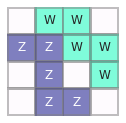

Solution took 1.7851 seconds
The areas are:[1. 1. 2. 1. 1.] giving 5.414 as a solution


In [5]:
# some setup and tests
N= [4,4]
solve_grid(N)

SETUP DONE .. in 2.7704 seconds


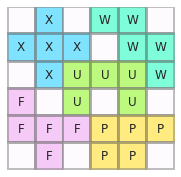

Solution took 19.5922 seconds
The areas are:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] giving 11.000 as a solution


In [6]:
N= [6,6]
solve_grid(N)

SETUP DONE .. in 5.7592 seconds


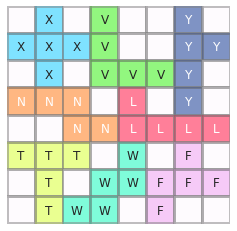

Solution took 13.2516 seconds
The areas are:[1. 1. 4. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 2. 1. 1. 2.] giving 19.657 as a solution


In [7]:
N= [8,8]

blank = [(0,0),(0,2),(0,4),(0,5),(0,7),
 (1,4),(1,5),
 (2,0),(2,2),(2,7),
 (3,3),(3,5),(3,7),
 (4,0),(4,1),
 (5,3),(5,5),(5,7),
 (6,0),(6,2),
 (7,0),(7,4),(7,6),(7,7)]

solve_grid(N,blank[:16])

In [8]:
url='https://www.janestreet.com/puzzles/pent-up-frustration-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([[i,j] for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:14]))))

### November 2018 : Solution

The highest-scoring configuration is shown here, scoring 14 + 4*sqrt(2), or
about
19.66
points.
The top 31-scoring entries we received all used exactly 8 pentominos; the
highest-scoring entry to use a different number of pentominos was 17.83 (which
used 9).

<img src="https://www.janestreet.com/puzzles/20181203_pent-up_ans.png" width = 200>